# Experiments with KAN Integration

## Install Necessary Libraries

In [ ]:
# Install necessary libraries
!pip install python-chess tensorflow numpy pandas matplotlib seaborn pyyaml ipywidgets torch scikit-learn

# Ensure ipywidgets is enabled
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py --sys-prefix ipywidgets

# Remove the existing pykan directory if it exists
import shutil
import os

if os.path.exists('pykan'):
    shutil.rmtree('pykan')

# Clone the pykan repository
!git clone https://github.com/KindXiaoming/pykan

# Change directory to pykan and install it
!pip install ./pykan




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.9/738.9 kB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 108.1 MB/s eta 0:00:00
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/local/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
 

# Experiment 1: Minimax Kane And Its Randomization Integrated with KAN

## Step 1: Overall Design
### Objective:
To integrate the Kolmogorov-Arnold Networks (KAN) model to analyze and interpret the equivalence between deterministic and randomized versions of a Minimax algorithm-based chess AI named Kane.

### Steps:
**Minimax Implementation:**

- Implement the deterministic version of the Minimax algorithm with heuristic evaluation for Kane.
- Introduce randomization to the evaluation function and move selection to create a randomized version.
**Game Simulation:**

- Simulate games using both the deterministic and randomized versions of Kane.
- Collect performance metrics during each game, including additional metrics like evaluation score, branching factor, depth of search, move diversity, and exploration vs. exploitation.
**Data Collection and Analysis:**

- Collect and aggregate the performance metrics from multiple games.
- Compare the aggregated metrics between the deterministic and randomized versions.
- Plot comparison metrics and equivalence curves to visualize the relationship.
**KAN Model Integration:**

- Define a custom KAN model architecture using PyTorch.
- Train the KAN model on the aggregated data from both deterministic and randomized versions.
- Evaluate the model's performance and track the equivalence score during training.
**Visualization:**
- Visualize the dataset.
- Extract and visualize the symbolic formula from the trained KAN model.
- Plot the model's structure and equivalence data points.
- Visualize the weights and biases of the trained KAN model.
**Statistical Analysis:**

- Perform statistical tests (t-test and F-test) to validate the results.
- Plot the results of the statistical analysis.
**Implementation:**
- Implement the KAN model using the provided KAN library.
- Train the KAN model with the training data from the deterministic and randomized versions.
- Calculate the equivalence score during each epoch of training.
- Use matplotlib for plotting and visualizing the results.

## Step 2: Minimax Implementation with Randomization for Kane
### 2.1: Deterministic Minimax Implementation

In [ ]:
import chess
from collections import defaultdict

# Deterministic Minimax Implementation
class KaneMinimaxDeterministic:
    def __init__(self, board):
        self.board = board
        self.evaluation_consistency = defaultdict(list)
        self.move_stability = defaultdict(int)
        self.search_paths = defaultdict(list)

    def heuristic_evaluation(self, board):
        # Enhanced heuristic evaluation function
        material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        mobility_count = len(list(board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())  # Simplified for demonstration
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())

        # Simplified scoring, can be improved with a better piece-square table
        score = material_count + mobility_count + piece_square_score + center_control_count
        return score

    def minimax(self, board, depth, is_maximizing_player):
        position_hash = hash(board.board_fen())
        if position_hash in self.evaluation_consistency and depth == 0:
            return self.evaluation_consistency[position_hash][-1]  # Return the last stored evaluation for consistency
        
        evaluation = self.heuristic_evaluation(board) if depth == 0 or board.is_game_over() else (
            self.minimax_search(board, depth, is_maximizing_player)
        )
        self.evaluation_consistency[position_hash].append(evaluation)
        return evaluation

    def minimax_search(self, board, depth, is_maximizing_player):
        if is_maximizing_player:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, False)
                board.pop()
                max_eval = max(max_eval, eval)
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, True)
                board.pop()
                min_eval = min(min_eval, eval)
            return min_eval

    def find_best_move_minimax(self, depth=3):
        position_hash = hash(self.board.board_fen())
        best_move = None
        best_value = float('-inf')
        for move in self.board.legal_moves:
            self.board.push(move)
            move_value = self.minimax(self.board, depth, False)
            self.board.pop()
            if move_value > best_value:
                best_value = move_value
                best_move = move
        self.move_stability[position_hash] += 1
        return best_move

    def track_search_path(self, board, move):
        position_hash = hash(board.board_fen())
        self.search_paths[position_hash].append(move.uci())


### 2.2: Introduce Randomization to the Evaluation Function and Move Selection

In [ ]:
# Pseudorandom Generator (PRG)
class PseudoRandom:
    def __init__(self, seed):
        self.state = seed

    def random(self):
        self.state = (1103515245 * self.state + 12345) % (2**31)
        return self.state / (2**31)

# Randomized Evaluation Function
class KaneMinimaxRandomization:
    def __init__(self, board, seed):
        self.board = board
        self.prng = PseudoRandom(seed)
        self.evaluation_consistency = defaultdict(list)
        self.move_stability = defaultdict(int)
        self.search_paths = defaultdict(list)

    def heuristic_evaluation(self, board):
        # Enhanced heuristic evaluation function with random component
        material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        mobility_count = len(list(board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())  # Simplified for demonstration
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())

        # Simplified scoring, can be improved with a better piece-square table
        score = material_count + mobility_count + piece_square_score + center_control_count

        # Random adjustment
        random_adjustment = int((self.prng.random() - 0.5) * 10)  # Random adjustment between -5 and +5
        return score + random_adjustment

    def minimax(self, board, depth, is_maximizing_player):
        position_hash = hash(board.board_fen())
        if position_hash in self.evaluation_consistency and depth == 0:
            return self.evaluation_consistency[position_hash][-1]  # Return the last stored evaluation for consistency
        
        evaluation = self.heuristic_evaluation(board) if depth == 0 or board.is_game_over() else (
            self.minimax_search(board, depth, is_maximizing_player)
        )
        self.evaluation_consistency[position_hash].append(evaluation)
        return evaluation

    def minimax_search(self, board, depth, is_maximizing_player):
        if is_maximizing_player:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, False)
                board.pop()
                max_eval = max(max_eval, eval)
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, True)
                board.pop()
                min_eval = min(min_eval, eval)
            return min_eval

    def find_best_move_minimax(self, depth=3):
        position_hash = hash(self.board.board_fen())
        best_move = None
        best_value = float('-inf')
        for move in self.board.legal_moves:
            self.board.push(move)
            move_value = self.minimax(self.board, depth, False)
            self.board.pop()
            if move_value > best_value:
                best_value = move_value
                best_move = move
        self.move_stability[position_hash] += 1
        return best_move

    def track_search_path(self, board, move):
        position_hash = hash(board.board_fen())
        self.search_paths[position_hash].append(move.uci())


### Step 3: Simulate Games Using Both Deterministic and Randomized Algorithms
### 3.1: Helper Functions for Metrics Calculation

In [ ]:
import time
import pandas as pd
from IPython.display import clear_output, display, SVG
import chess.svg
import numpy as np

# Function to calculate additional metrics
def calculate_metrics(board):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())  # Simplified for demonstration
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    return material_count, mobility_count, piece_square_score, center_control_count

def calculate_additional_metrics(board, move_scores, current_depth, is_exploratory):
    evaluation_score = sum(move_scores) / len(move_scores) if move_scores else 0
    branching_factor = len(list(board.legal_moves))
    depth_of_search = current_depth
    move_diversity = np.var(move_scores) if move_scores else 0
    exploration_vs_exploitation = 1 if is_exploratory else 0
    return evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation


### 3.2: Function to Play the Game with Deterministic Minimax

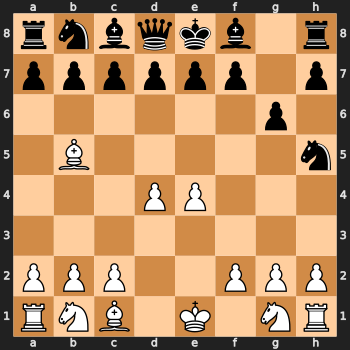

Move: d2d4
Step: 8, Time: 54.027533769607544, Material: -1, Mobility: 20, Piece-Square: -1, Center Control: 2
Stop the game in advance!
Result: *
   Step       Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1  26.574454  e2e4               0              20                   0   
1     2  52.008635  g8f6               0              30                   0   
2     3  61.685943  f1b5               0              19                   0   
3     4  51.219210  g7g6               0              34                   0   
4     5  65.651583  d1h5               0              20                   0   
5     6  91.660734  f6h5              -1              31                  -1   
6     7  54.027534  d2d4              -1              20                  -1   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     1              37.0                20                3   
1                     1               8.0            

In [ ]:
# Function to play the game with deterministic Minimax
def play_game_minimax_deterministic(kane_minimax, depth=3, max_moves=55, max_runtime=600):
    steps = []
    times = []
    material_counts = []
    mobility_counts = []
    piece_square_scores = []
    center_control_counts = []
    move_list = []
    evaluation_scores = []
    branching_factors = []
    depths_of_search = []
    move_diversities = []
    exploration_vs_exploitations = []
    step_number = 1

    start_time = time.time()
    while not kane_minimax.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        best_move = kane_minimax.find_best_move_minimax(depth)
        move_end_time = time.time()

        kane_minimax.board.push(best_move)
        kane_minimax.track_search_path(kane_minimax.board, best_move)

        move_list.append(best_move.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)

        # Calculate metrics
        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(kane_minimax.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        # Collect additional metrics
        move_scores = [kane_minimax.minimax(kane_minimax.board, depth, False) for move in kane_minimax.board.legal_moves]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            kane_minimax.board, move_scores, depth, False)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=kane_minimax.board, size=350)))

        time.sleep(1)
        print(f"Move: {best_move}")
        print(f"Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {material_count}, Mobility: {mobility_count}, Piece-Square: {piece_square_score}, Center Control: {center_control_count}")

    # Create a DataFrame for the collected data
    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)

    print("Stop the game in advance!")
    print(f"Result: {kane_minimax.board.result()}")
    print(df)
    return df

# Initialize the boards and engines
board_deterministic = chess.Board()
kane_deterministic = KaneMinimaxDeterministic(board_deterministic)

# Simulate and run the deterministic game
print("Running deterministic game...")
deterministic_results = [play_game_minimax_deterministic(kane_deterministic)]


### 3.3: Function to Play the Game with Randomized Minimax

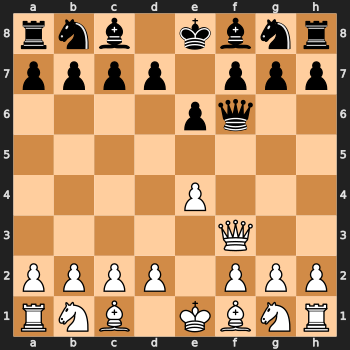

Move: d8f6
Step: 5, Time: 148.13759517669678, Material: 0, Mobility: 38, Piece-Square: 0, Center Control: 1
Stop the game in advance!
Result: *
   Step        Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1   26.127074  e2e4               0              20                   0   
1     2   52.105003  e7e6               0              30                   0   
2     3  101.529763  d1f3               0              30                   0   
3     4  148.137595  d8f6               0              38                   0   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     1              35.0                20                3   
1                     1              10.0                30                3   
2                     1              29.0                30                3   
3                     1              23.0                38                3   

   Move Diversity  Exploration vs Exploitation  


In [ ]:
# Function to play the game with randomized Minimax
def play_game_minimax_randomized(kane_minimax, depth=3, max_moves=55, max_runtime=600):
    steps = []
    times = []
    material_counts = []
    mobility_counts = []
    piece_square_scores = []
    center_control_counts = []
    move_list = []
    evaluation_scores = []
    branching_factors = []
    depths_of_search = []
    move_diversities = []
    exploration_vs_exploitations = []
    step_number = 1

    start_time = time.time()
    while not kane_minimax.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        best_move = kane_minimax.find_best_move_minimax(depth)
        move_end_time = time.time()

        kane_minimax.board.push(best_move)
        kane_minimax.track_search_path(kane_minimax.board, best_move)

        move_list.append(best_move.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)

        # Calculate metrics
        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(kane_minimax.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        # Collect additional metrics
        move_scores = [kane_minimax.minimax(kane_minimax.board, depth, False) for move in kane_minimax.board.legal_moves]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            kane_minimax.board, move_scores, depth, False)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=kane_minimax.board, size=350)))

        time.sleep(1)
        print(f"Move: {best_move}")
        print(f"Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {material_count}, Mobility: {mobility_count}, Piece-Square: {piece_square_score}, Center Control: {center_control_count}")

    # Create a DataFrame for the collected data
    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)

    print("Stop the game in advance!")
    print(f"Result: {kane_minimax.board.result()}")
    print(df)
    return df

# Initialize the boards and engines
board_randomized = chess.Board()
kane_randomized = KaneMinimaxRandomization(board_randomized, seed=42)

# Simulate and run the randomized game
print("Running randomized game...")
randomized_results = [play_game_minimax_randomized(kane_randomized)]


## Step 4: Collect and Analyze Performance Metrics
### 4.1: Collect Evaluation Consistency Data

In [ ]:
# Collect evaluation consistency data
evaluation_consistency_df = pd.DataFrame.from_dict(kane_deterministic.evaluation_consistency, orient='index').transpose()
evaluation_consistency_df = evaluation_consistency_df.ffill()

# Collect move stability data
move_stability_df = pd.DataFrame.from_dict(kane_deterministic.move_stability, orient='index', columns=['Move Stability'])

# Collect search path data
search_paths_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in kane_deterministic.search_paths.items()]))

# Debugging print statements
print("Evaluation Consistency DataFrame:\n", evaluation_consistency_df.head())
print("Move Stability DataFrame:\n", move_stability_df.head())
print("Search Paths DataFrame:\n", search_paths_df.head())


Evaluation Consistency DataFrame:
    -7505913410481916543  -4583441966672292120   7488238774901066193  \
0                  25.0                  25.0                  25.0   
1                  25.0                  25.0                  25.0   
2                  25.0                  25.0                  25.0   
3                  25.0                  25.0                  25.0   
4                  25.0                  25.0                  25.0   

   -169452892001333734   -6553352076254853471   4816355135184235134  \
0                  25.0                  25.0                  24.0   
1                  25.0                  25.0                  24.0   
2                  25.0                  25.0                  24.0   
3                  25.0                  25.0                  24.0   
4                  25.0                  25.0                  24.0   

   -8265108269776547714   5907027515905743247   3468198609997943119  \
0                  25.0                 

### 4.2: Ensure Results are DataFrames and Aggregate Metrics

In [ ]:
# Function to ensure all results are DataFrames and handle errors
def ensure_dataframe(result):
    if isinstance(result, pd.DataFrame):
        return result
    try:
        return pd.DataFrame(result)
    except Exception as e:
        print("Error converting to DataFrame:", e)
        return pd.DataFrame()

# Convert results to DataFrames
deterministic_results = [ensure_dataframe(df) for df in deterministic_results]
randomized_results = [ensure_dataframe(df) for df in randomized_results]

# Print structures for debugging
print("\nDeterministic Results Sample:\n", deterministic_results[0].head() if deterministic_results else "No Data")
print("\nRandomized Results Sample:\n", randomized_results[0].head() if randomized_results else "No Data")

# Aggregate and analyze the results
def aggregate_metrics(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    
    # Ensure results is a list of DataFrame objects
    aggregated_data = pd.concat(results, ignore_index=True)
    
    # Print columns to debug
    print("\nAggregated Data Columns:\n", aggregated_data.columns)
    
    mean_metrics = aggregated_data[numeric_columns].mean()
    std_metrics = aggregated_data[numeric_columns].std()
    
    return mean_metrics, std_metrics, aggregated_data

# Aggregate the results
deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

# Display the aggregated metrics
print("Deterministic Mean Metrics:\n", deterministic_mean)
print("Deterministic Std Metrics:\n", deterministic_std)
print("\nRandomized Mean Metrics:\n", randomized_mean)
print("Randomized Std Metrics:\n", randomized_std)

# Display move sequences and non-numeric data
print("\nDeterministic Moves:\n", deterministic_data['Move'])
print("\nRandomized Moves:\n", randomized_data['Move'])



Deterministic Results Sample:
    Step       Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1  26.574454  e2e4               0              20                   0   
1     2  52.008635  g8f6               0              30                   0   
2     3  61.685943  f1b5               0              19                   0   
3     4  51.219210  g7g6               0              34                   0   
4     5  65.651583  d1h5               0              20                   0   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     1              37.0                20                3   
1                     1               8.0                30                3   
2                     1              27.0                19                3   
3                     1               8.0                34                3   
4                     1              28.0                20                3   

   Mov

## Step 5: Compare the Deterministic and Randomized Algorithms and Generate Equivalence Curves


Aggregated Data Columns:
 Index(['Step', 'Time', 'Move', 'Material Count', 'Mobility Count',
       'Piece-Square Score', 'Center Control Count', 'Evaluation Score',
       'Branching Factor', 'Depth of Search', 'Move Diversity',
       'Exploration vs Exploitation'],
      dtype='object')

Aggregated Data Columns:
 Index(['Step', 'Time', 'Move', 'Material Count', 'Mobility Count',
       'Piece-Square Score', 'Center Control Count', 'Evaluation Score',
       'Branching Factor', 'Depth of Search', 'Move Diversity',
       'Exploration vs Exploitation'],
      dtype='object')
Deterministic Mean Metrics:
 Material Count                 -0.285714
Mobility Count                 24.857143
Piece-Square Score             -0.285714
Center Control Count            1.142857
Evaluation Score               22.571429
Branching Factor               24.857143
Depth of Search                 3.000000
Move Diversity                  0.000000
Exploration vs Exploitation     0.000000
dtype: float64
Det

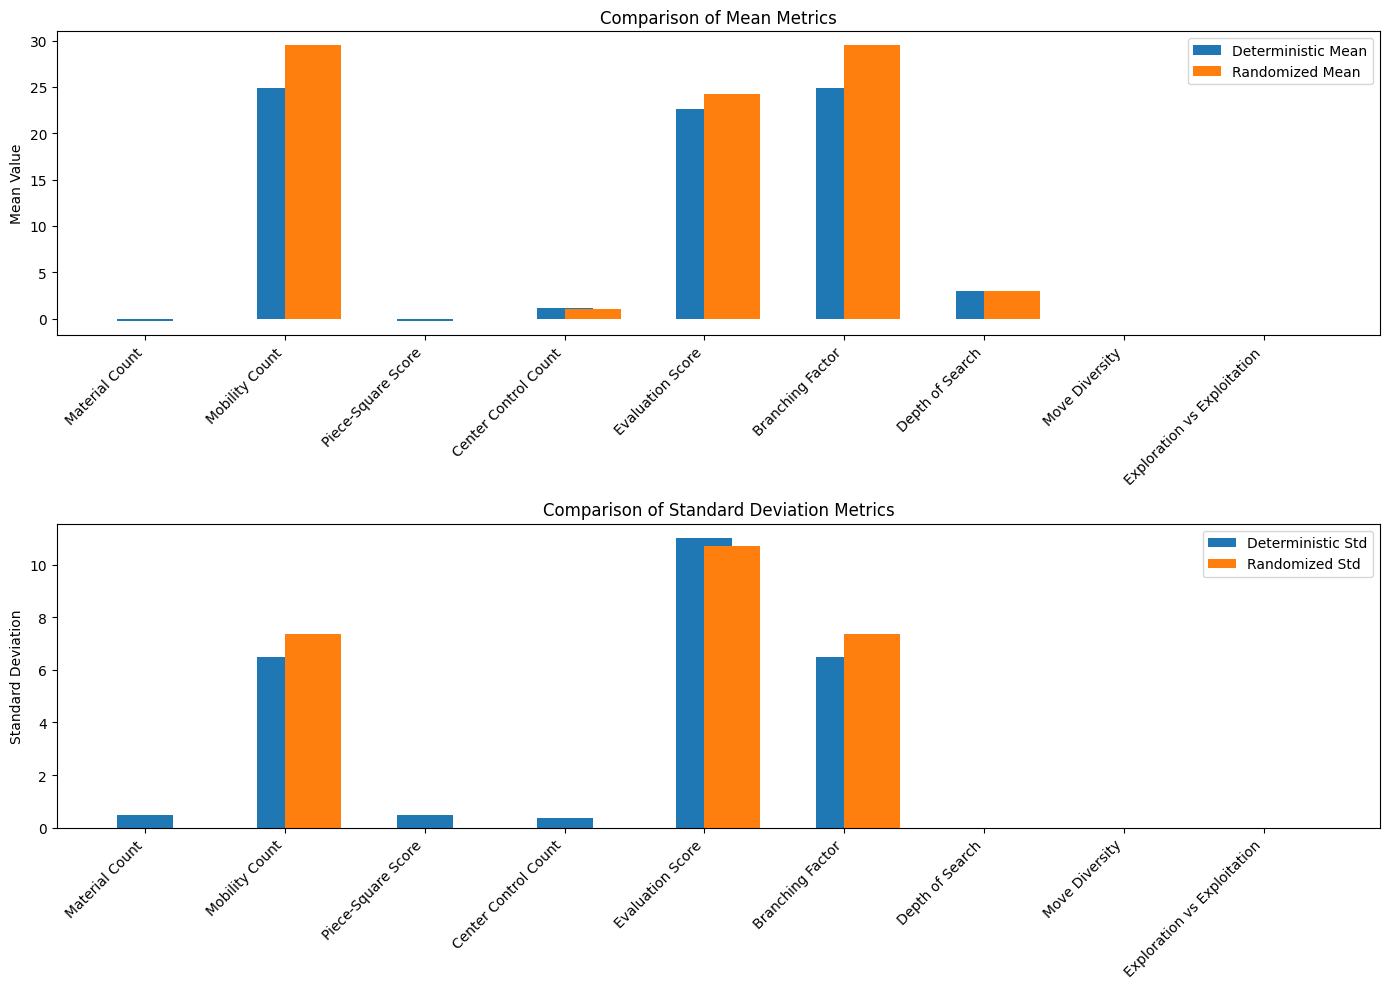

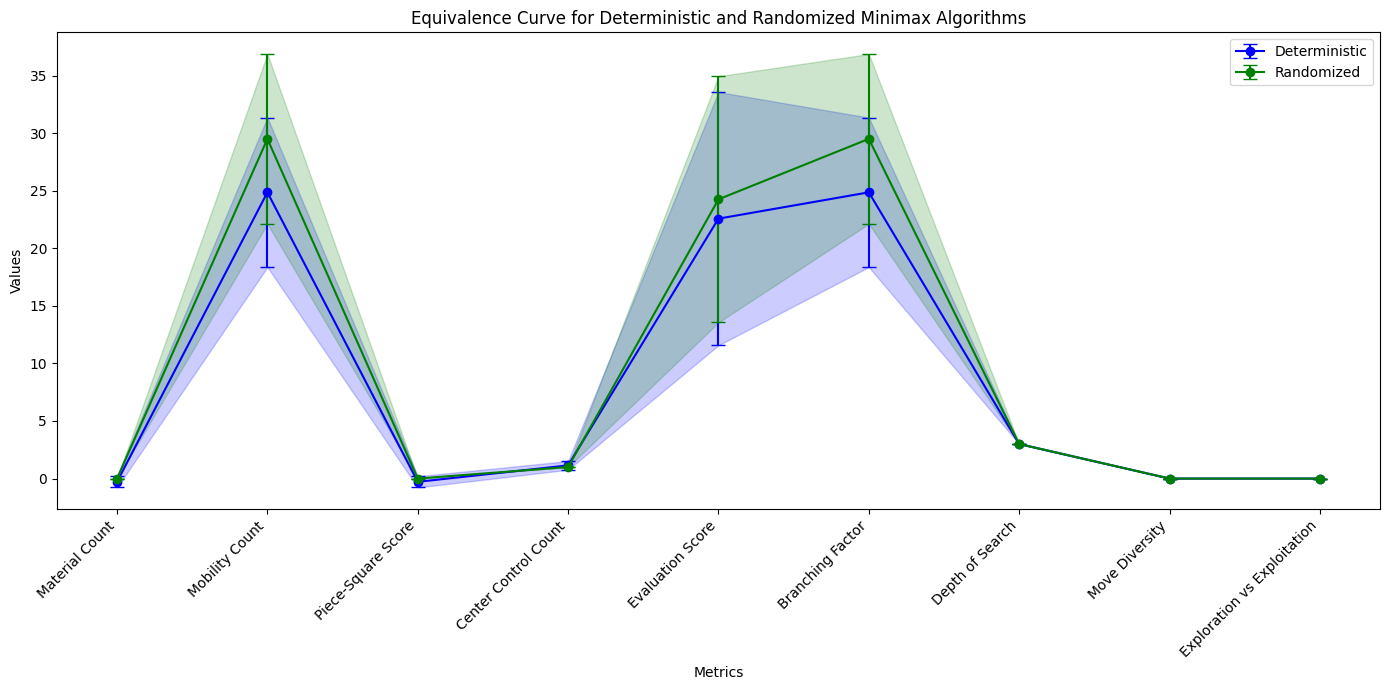

In [ ]:
import matplotlib.pyplot as plt

# Function to compare Kane versions
def compare_kane_versions(deterministic_results, randomized_results):
    deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
    randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

    # Display the aggregated metrics
    print("Deterministic Mean Metrics:\n", deterministic_mean)
    print("Deterministic Std Metrics:\n", deterministic_std)
    print("\nRandomized Mean Metrics:\n", randomized_mean)
    print("Randomized Std Metrics:\n", randomized_std)

    # Plot comparison metrics
    def plot_comparison_metrics(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
        metrics = deterministic_mean.index
        x = range(len(metrics))

        fig, axs = plt.subplots(2, 1, figsize=(14, 10))

        # Plot means
        axs[0].bar(x, deterministic_mean, width=0.4, label='Deterministic Mean', align='center')
        axs[0].bar(x, randomized_mean, width=0.4, label='Randomized Mean', align='edge')
        axs[0].set_xticks(x)
        axs[0].set_xticklabels(metrics, rotation=45, ha='right')
        axs[0].set_ylabel('Mean Value')
        axs[0].set_title('Comparison of Mean Metrics')
        axs[0].legend()

        # Plot standard deviations
        axs[1].bar(x, deterministic_std, width=0.4, label='Deterministic Std', align='center')
        axs[1].bar(x, randomized_std, width=0.4, label='Randomized Std', align='edge')
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(metrics, rotation=45, ha='right')
        axs[1].set_ylabel('Standard Deviation')
        axs[1].set_title('Comparison of Standard Deviation Metrics')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    # Plot comparison metrics
    plot_comparison_metrics(deterministic_mean, deterministic_std, randomized_mean, randomized_std)

    # Plot equivalence curve
    def plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
        metrics = deterministic_mean.index
        x = np.arange(len(metrics))

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(14, 7))

        # Plot deterministic means with error bars for std
        ax.errorbar(x, deterministic_mean, yerr=deterministic_std, fmt='o-', label='Deterministic', color='blue', capsize=5)

        # Plot randomized means with error bars for std
        ax.errorbar(x, randomized_mean, yerr=randomized_std, fmt='o-', label='Randomized', color='green', capsize=5)

        # Fill between for deterministic std
        ax.fill_between(x, deterministic_mean - deterministic_std, deterministic_mean + deterministic_std, color='blue', alpha=0.2)

        # Fill between for randomized std
        ax.fill_between(x, randomized_mean - randomized_std, randomized_mean + randomized_std, color='green', alpha=0.2)

        # Add title and labels
        ax.set_title('Equivalence Curve for Deterministic and Randomized Minimax Algorithms')
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, ha='right')

        # Add legend
        ax.legend()

        # Show plot
        plt.tight_layout()
        plt.show()

    # Plot equivalence curve
    plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std)

# Compare the results
compare_kane_versions(deterministic_results, randomized_results)


## Step 6: Verification and Conclusion
### 6.1: Simulate Multiple Games

In [ ]:
def compare_kane_versions(deterministic_kane, randomized_kane, depth=3, games=5, max_moves=55, max_runtime=600):
    deterministic_results = []
    randomized_results = []

    for _ in range(games):
        # Play game with deterministic Kane
        deterministic_kane.board.reset()
        deterministic_data = play_game_minimax_deterministic(deterministic_kane, depth, max_moves, max_runtime)
        deterministic_results.append(deterministic_data)

        # Play game with randomized Kane
        randomized_kane.board.reset()
        randomized_data = play_game_minimax_randomized(randomized_kane, depth, max_moves, max_runtime)
        randomized_results.append(randomized_data)

    return deterministic_results, randomized_results

# Initialize the boards and engines
board_deterministic = chess.Board()
kane_deterministic = KaneMinimaxDeterministic(board_deterministic)

board_randomized = chess.Board()
kane_randomized = KaneMinimaxRandomization(board_randomized, seed=42)

# Compare the two versions over multiple games
deterministic_results, randomized_results = compare_kane_versions(kane_deterministic, kane_randomized)


NameError: name 'play_game_minimax_deterministic' is not defined

### 6.2: Aggregate Additional Data

In [ ]:
# Run additional games to gather more data
additional_games = 10
deterministic_results_additional, randomized_results_additional = compare_kane_versions(kane_deterministic, kane_randomized, games=additional_games)

# Aggregate the additional data
deterministic_mean_additional, deterministic_std_additional, deterministic_data_additional = aggregate_metrics(deterministic_results_additional)
randomized_mean_additional, randomized_std_additional, randomized_data_additional = aggregate_metrics(randomized_results_additional)

# Combine the original and additional data
combined_deterministic_data = pd.concat([deterministic_data, deterministic_data_additional], ignore_index=True)
combined_randomized_data = pd.concat([randomized_data, randomized_data_additional], ignore_index=True)

# Recalculate the means and standard deviations
combined_deterministic_mean, combined_deterministic_std = combined_deterministic_data.mean(), combined_deterministic_data.std()
combined_randomized_mean, combined_randomized_std = combined_randomized_data.mean(), combined_randomized_data.std()

# Display the combined metrics
print("Combined Deterministic Mean Metrics:\n", combined_deterministic_mean)
print("Combined Deterministic Std Metrics:\n", combined_deterministic_std)
print("\nCombined Randomized Mean Metrics:\n", combined_randomized_mean)
print("Combined Randomized Std Metrics:\n", combined_randomized_std)

# Equivalence Curve
def plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
    metrics = deterministic_mean.index
    x = np.arange(len(metrics))

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot deterministic means with error bars for std
    ax.errorbar(x, deterministic_mean, yerr=deterministic_std, fmt='o-', label='Deterministic', color='blue', capsize=5)

    # Plot randomized means with error bars for std
    ax.errorbar(x, randomized_mean, yerr=randomized_std, fmt='o-', label='Randomized', color='green', capsize=5)

    # Fill between for deterministic std
    ax.fill_between(x, deterministic_mean - deterministic_std, deterministic_mean + deterministic_std, color='blue', alpha=0.2)

    # Fill between for randomized std
    ax.fill_between(x, randomized_mean - randomized_std, randomized_mean + randomized_std, color='green', alpha=0.2)

    # Add title and labels
    ax.set_title('Equivalence Curve for Deterministic and Randomized Minimax Algorithms')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')

    # Add legend
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot equivalence curve
plot_equivalence_curve(combined_deterministic_mean, combined_deterministic_std, combined_randomized_mean, combined_randomized_std)


## Step 7: Perform Statistical Tests

In [ ]:
# Statistical Analysis
from scipy.stats import ttest_ind, f_oneway

# Function to perform statistical tests
def perform_statistical_tests(deterministic_metrics, randomized_metrics):
    results = {}
    for metric in deterministic_metrics.index:
        t_stat, p_value_t = ttest_ind(deterministic_data[metric], randomized_data[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(deterministic_data[metric], randomized_data[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

# Perform statistical tests
statistical_results = perform_statistical_tests(deterministic_mean, randomized_mean)

# Display the results
for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")

# Plot statistical analysis results
def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot t-statistics
    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    # Plot p-values (t-test)
    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')

    plt.tight_layout()
    plt.show()

# Plot statistical analysis results
plot_statistical_analysis(statistical_results)


## Step 8: Integrate KAN Model
### 8.1: Define KAN Model and Training Function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from kan import KAN

class CustomKAN(nn.Module):
    def __init__(self, width, grid, k):
        super(CustomKAN, self).__init__()
        self.kan = KAN(width=width, grid=grid, k=k)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.kan(x)
        x = self.dropout(x)
        return x

# Helper function to train KAN model
def train_kan_model(train_input, train_label, test_input, test_label, num_epochs=5000):
    model = CustomKAN(width=[5, 10, 5], grid=3, k=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []
    equivalence_scores = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_input)
        loss = loss_fn(outputs, train_label)
        loss.backward()
        optimizer.step()
        scheduler.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == train_label).sum().item()
        train_acc = correct / len(train_label)

        model.eval()
        test_outputs = model(test_input)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_correct = (test_predicted == test_label).sum().item()
        test_acc = test_correct / len(test_label)

        train_losses.append(loss.item())
        test_accuracies.append(test_acc)

        min_length = min(len(train_input), len(test_input))
        f_kan_a = model(train_input[:min_length]).detach().numpy()
        f_kan_b = model(test_input[:min_length]).detach().numpy()
        numerator = np.linalg.norm(f_kan_a - f_kan_b)
        denominator = np.linalg.norm(f_kan_a) + np.linalg.norm(f_kan_b)
        equivalence_score = 1 - (numerator / denominator)
        equivalence_scores.append(equivalence_score)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Equivalence Score: {equivalence_score:.4f}')

    return model, equivalence_scores


### 8.2: Compare Kane Versions and Integrate KAN Model

In [ ]:
def compare_kane_versions(deterministic_results, randomized_results):
    deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
    randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

    # Display the aggregated metrics
    print("Deterministic Mean Metrics:\n", deterministic_mean)
    print("Deterministic Std Metrics:\n", deterministic_std)
    print("\nRandomized Mean Metrics:\n", randomized_mean)
    print("Randomized Std Metrics:\n", randomized_std)

    combined_deterministic_data = pd.concat(deterministic_results, ignore_index=True)
    combined_randomized_data = pd.concat(randomized_results, ignore_index=True)

    train_input = torch.from_numpy(combined_deterministic_data.values).float()
    test_input = torch.from_numpy(combined_randomized_data.values).float()
    train_label = torch.from_numpy(np.ones(len(train_input))).long()
    test_label = torch.from_numpy(np.zeros(len(test_input))).long()

    kan_model, equivalence_scores = train_kan_model(train_input, train_label, test_input, test_label)

    return kan_model, equivalence_scores

# Compare the two versions over multiple games
kan_model, equivalence_scores = compare_kane_versions(deterministic_results, randomized_results)


## Step 9: Visualize Results
### 9.1: Visualize Dataset and Extract Results from KAN Model

In [ ]:
# Visualize the dataset
X = combined_deterministic_data.values
y = combined_randomized_data.values
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

# Ensure the required image is in place for plotting
img_src_path = '/work/pykan/kan/assets/img/sum_symbol.png'
img_dest_path = '/root/venv/lib/python3.9/site-packages/kan/assets/img/sum_symbol.png'
if not os.path.exists(img_dest_path):
    os.makedirs(os.path.dirname(img_dest_path), exist_ok=True)
    os.system(f'cp {img_src_path} {img_dest_path}')

# Extract symbolic formula
symbolic_formula = kan_model.kan.symbolic_formula()
print(f'Symbolic Formula: {symbolic_formula}')

# Plot model structure
try:
    kan_model.kan.plot()
    plt.show()
except FileNotFoundError as e:
    print(f"Error plotting model: {e}")

# Prepare data for plotting
train_predictions = kan_model(torch.from_numpy(train_input).float()).detach().numpy()
test_predictions = kan_model(torch.from_numpy(test_input).float()).detach().numpy()

# Plot equivalence score
plt.figure(figsize=(10, 6))
plt.plot(range(len(equivalence_scores)), equivalence_scores, label='Equivalence Score')
plt.xlabel('Epoch')
plt.ylabel('Equivalence Score')
plt.title('Equivalence Score')
plt.legend()
plt.savefig('equivalence_curve.png')
plt.show()

# Plot equivalence curve
plt.figure(figsize=(10, 6))
plt.plot(train_predictions.flatten(), label='Deterministic Output')
plt.plot(test_predictions.flatten(), label='Randomized Output', linestyle='--')
plt.xlabel('Data Points')
plt.ylabel('Model Output')
plt.title('Equivalence Data Points')
plt.legend()
plt.savefig('equivalence_data_points.png')
plt.show()

# Extract the weights and biases from the trained KAN model
weights = kan_model.kan.state_dict()

# List the available keys
keys = list(weights.keys())
print("Available keys in the model's state dictionary:", keys)

def visualize_weights(key):
    data = weights[key].detach().numpy()
    if data.ndim == 1:
        data = data.reshape(-1, 1)  # Reshape to 2D if it's 1D
    elif data.ndim == 3:
        # For 3D data, we'll visualize the first slice
        data = data[:, :, 0]
    sns.heatmap(data, annot=True, cmap='coolwarm')
    plt.title(f'Visualization of {key}')
    plt.show()

# Visualize the available weights and biases
for key in keys:
    visualize_weights(key)


# Experiment 2: Simple NN based Abel And Its De-Randomization Integrated with KAN

## Step 1: Overall Design Description
### Objective:
To integrate the Kolmogorov-Arnold Networks (KAN) model to analyze and interpret the equivalence between probabilistic and deterministic versions of a simple neural network-based chess AI named Abel.

### Steps:

**Data Preparation:**

- Train the Simple NN-based Abel with both probabilistic and deterministic versions.
- Collect performance metrics such as material count, mobility count, piece-square score, and center control count.
**Training and Evaluation:**

- Define a custom KAN model architecture using PyTorch.
- Train the KAN model on the collected data.
- Evaluate the model's performance and track the equivalence score during training.
### Visualization:

- Visualize the dataset.
- Plot the equivalence curve to show the relationship between the deterministic and probabilistic versions.
- Extract and visualize the symbolic formula from the trained KAN model.
- Plot the model's structure and equivalence data points.
- Visualize the weights and biases of the trained KAN model.
### Implementation:

- Implement the KAN model using the provided KAN library.
- Train the KAN model with the training data and evaluate it with test data.
- Calculate the equivalence score during each epoch of training.
- Use matplotlib for plotting and visualizing the results.

## Step 2: Define the Simple Neural Network for Abel
### 2.1: Import Required Libraries and Define Helper Functions

In [ ]:
import chess
import chess.svg
from IPython.display import display, clear_output, SVG
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway

import os
import torch
import torch.nn as nn
import seaborn as sns
from kan import KAN
from sklearn.preprocessing import StandardScaler

# Setting up constants
gamma = 0.95
batch_size = 32
target_update_freq = 10

# Helpers for derandomization
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def softmax_policy(q_values, temperature):
    q_values = np.array(q_values)  # Convert list to numpy array
    exp_values = np.exp(q_values / temperature)
    probabilities = exp_values / np.sum(exp_values)
    return np.argmax(probabilities)

# Heuristic Evaluation
def heuristic_evaluation(board):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    score = material_count + mobility_count + piece_square_score + center_control_count
    return score

# Define the Game Environment
class ChessEnv:
    def __init__(self):
        self.board = chess.Board()
    
    def reset(self):
        self.board.reset()
        return self.board
    
    def step(self, state, action):
        self.board.push(action)
        reward = heuristic_evaluation(self.board)
        done = self.board.is_game_over()
        return self.board, reward, done
    
    def legal_moves(self, state):
        return list(state.legal_moves)
    
    def simulate_move(self, state, move):
        temp_board = state.copy()
        temp_board.push(move)
        return temp_board

# Define the Simple NN Model
class AbelNN:
    def __init__(self, seed):
        self.model = self.build_model(seed)
    
    def build_model(self, seed):
        np.random.seed(seed)
        tf.random.set_seed(seed)
        model = Sequential([
            Flatten(input_shape=(8, 8, 12)),  # Ensure this matches the shape of the input
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model
    
    def evaluate_board(self, board):
        board_state = self.board_to_input(board)
        return self.model.predict(board_state, verbose=0)[0][0]
    
    def board_to_input(self, board):
        input_array = np.zeros((8, 8, 12))
        piece_to_index = {
            'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
            'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
        }
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                x, y = divmod(square, 8)
                input_array[x, y, piece_to_index[piece.symbol()]] = 1
        return np.array([input_array])


## Step 3: Training Functions
### 3.1: Training the Original Simple NN

In [ ]:
def train_simple_nn(env, num_episodes=10, seed=42, temperature=1.0):
    nn = AbelNN(seed)
    set_random_seed(seed)
    
    for e in range(num_episodes):
        state = env.reset()
        done = False
        
        while not done:
            q_values = [nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            target = reward + heuristic_evaluation(next_state)
            state_input = nn.board_to_input(state)
            nn.model.fit(state_input, np.array([target]), epochs=1, verbose=0)
            state = next_state

    return nn

# Training the original Simple NN
print("Training the original Simple NN...")
env = ChessEnv()
abel_nn_probabilistic = train_simple_nn(env, num_episodes=5, seed=42, temperature=1.0)


### 3.2: Training the Derandomized Simple NN

In [ ]:
def update_nn(abel_nn, target_network, batch):
    states, actions, rewards, next_states, dones = zip(*batch)
    target_q_values = [target_network.evaluate_board(state) for state in next_states]
    targets = rewards + (1 - np.array(dones)) * np.array(target_q_values)
    states = np.array([abel_nn.board_to_input(state).reshape(-1, 8, 8, 12) for state in states])
    targets = np.array(targets).reshape(-1, 1)
    print(f"Updating NN: states shape: {states.shape}, targets shape: {targets.shape}")
    abel_nn.model.train_on_batch(np.vstack(states), targets)

def train_abel_nn_derandomized(env, num_episodes, seed, temperature):
    set_random_seed(seed)
    abel_nn = AbelNN(seed)
    target_network = AbelNN(seed)
    replay_buffer = []
    batch_size = 32
    target_update_freq = 10

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            
            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)
                update_nn(abel_nn, target_network, batch)
        
        if episode % target_update_freq == 0:
            target_network.model.set_weights(abel_nn.model.get_weights())
    
    return abel_nn

# Training the derandomized Simple NN
print("Training the derandomized Simple NN...")
env = ChessEnv()
abel_nn_derandomized = train_abel_nn_derandomized(env, num_episodes=5, seed=42, temperature=1.0)


## Step 4: Simulate Games using Simple NN
### 4.1: Play Game with Probabilistic NN

In [ ]:
def play_game_nn_probabilistic(abel_nn, env, max_moves=55, max_runtime=600, temperature=1.0):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)

        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0

        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df


### 4.3: Function to Play the Game with Derandomized NN

In [ ]:
def play_game_nn_derandomized(abel_nn, env, max_moves=55, max_runtime=600, temperature=0.5):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)

        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0

        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df


## Step 5: Compare Abel Versions
###  5.1: Define KAN Model and Training Function

In [ ]:
class CustomKAN(nn.Module):
    def __init__(self, width, grid, k):
        super(CustomKAN, self).__init__()
        self.kan = KAN(width=width, grid=grid, k=k)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.kan(x)
        x = self.dropout(x)
        return x

# Helper function to train KAN model
def train_kan_model(train_input, train_label, test_input, test_label, num_epochs=5000):
    model = CustomKAN(width=[5, 10, 5], grid=3, k=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []
    equivalence_scores = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_input)
        loss = loss_fn(outputs, train_label)
        loss.backward()
        optimizer.step()
        scheduler.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == train_label).sum().item()
        train_acc = correct / len(train_label)

        model.eval()
        test_outputs = model(test_input)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_correct = (test_predicted == test_label).sum().item()
        test_acc = test_correct / len(test_label)

        train_losses.append(loss.item())
        test_accuracies.append(test_acc)

        min_length = min(len(train_input), len(test_input))
        f_kan_a = model(train_input[:min_length]).detach().numpy()
        f_kan_b = model(test_input[:min_length]).detach().numpy()
        numerator = np.linalg.norm(f_kan_a - f_kan_b)
        denominator = np.linalg.norm(f_kan_a) + np.linalg.norm(f_kan_b)
        equivalence_score = 1 - (numerator / denominator)
        equivalence_scores.append(equivalence_score)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Equivalence Score: {equivalence_score:.4f}')

    return model, equivalence_scores


### 5.2: Define compare_abel_versions Function

In [ ]:
def compare_abel_versions(probabilistic_nn, derandomized_nn, env, games=5, max_moves=55, max_runtime=300):
    probabilistic_results = []
    derandomized_results = []

    for _ in range(games):
        env.reset()
        probabilistic_data = play_game_nn_probabilistic(probabilistic_nn, env, max_moves, max_runtime)
        probabilistic_results.append(probabilistic_data)

        env.reset()
        derandomized_data = play_game_nn_derandomized(derandomized_nn, env, max_moves, max_runtime)
        derandomized_results.append(derandomized_data)

    probabilistic_results = [ensure_dataframe(df) for df in probabilistic_results]
    derandomized_results = [ensure_dataframe(df) for df in derandomized_results]

    probabilistic_mean, probabilistic_std, probabilistic_data = aggregate_metrics(probabilistic_results)
    derandomized_mean, derandomized_std, derandomized_data = aggregate_metrics(derandomized_results)

    combined_probabilistic_data = pd.concat(probabilistic_results, ignore_index=True)
    combined_derandomized_data = pd.concat(derandomized_results, ignore_index=True)

    combined_probabilistic_mean = combined_probabilistic_data[numeric_columns].mean()
    combined_probabilistic_std = combined_probabilistic_data[numeric_columns].std()
    combined_derandomized_mean = combined_derandomized_data[numeric_columns].mean()
    combined_derandomized_std = combined_derandomized_data[numeric_columns].std()

    train_input = torch.from_numpy(combined_probabilistic_mean.values.reshape(-1, 1)).float()
    test_input = torch.from_numpy(combined_derandomized_mean.values.reshape(-1, 1)).float()
    train_label = torch.from_numpy(np.ones(len(train_input))).long()
    test_label = torch.from_numpy(np.zeros(len(test_input))).long()

    kan_model, equivalence_scores = train_kan_model(train_input, train_label, test_input, test_label)

    return probabilistic_results, derandomized_results, kan_model, equivalence_scores

# Compare the two versions over multiple games
probabilistic_results, derandomized_results, kan_model, equivalence_scores = compare_abel_versions(abel_nn_probabilistic, abel_nn_derandomized, env, games=5)


### Step 6: Aggregate Data and Calculate Metrics

In [ ]:
# Aggregate metrics function
def aggregate_metrics(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    aggregated_data = pd.concat(results, ignore_index=True)
    mean_metrics = aggregated_data[numeric_columns].mean()
    std_metrics = aggregated_data[numeric_columns].std()
    return mean_metrics, std_metrics, aggregated_data

# Convert results to DataFrames
probabilistic_results = [ensure_dataframe(df) for df in probabilistic_results]
derandomized_results = [ensure_dataframe(df) for df in derandomized_results]

# Aggregate the results
probabilistic_mean, probabilistic_std, probabilistic_data = aggregate_metrics(probabilistic_results)
derandomized_mean, derandomized_std, derandomized_data = aggregate_metrics(derandomized_results)

# Display the aggregated metrics
print("Probabilistic NN Mean Metrics:\n", probabilistic_mean)
print("Probabilistic NN Std Metrics:\n", probabilistic_std)
print("\nDerandomized NN Mean Metrics:\n", derandomized_mean)
print("Derandomized NN Std Metrics:\n", derandomized_std)

# Display move sequences and non-numeric data
print("\nProbabilistic Moves:\n", probabilistic_data['Move'])
print("\nDerandomized Moves:\n", derandomized_data['Move'])


## Step 7: Plot Comparison Metrics and Equivalence Curve

In [ ]:
# Plot comparison metrics
def plot_comparison_metrics(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std):
    metrics = probabilistic_mean.index
    x = range(len(metrics))

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot means
    axs[0].bar(x, probabilistic_mean, width=0.4, label='Probabilistic Mean', align='center')
    axs[0].bar(x, derandomized_mean, width=0.4, label='Derandomized Mean', align='edge')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('Mean Value')
    axs[0].set_title('Comparison of Mean Metrics')
    axs[0].legend()

    # Plot standard deviations
    axs[1].bar(x, probabilistic_std, width=0.4, label='Probabilistic Std', align='center')
    axs[1].bar(x, derandomized_std, width=0.4, label='Derandomized Std', align='edge')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].set_ylabel('Standard Deviation')
    axs[1].set_title('Comparison of Standard Deviation Metrics')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Plot the comparison metrics
plot_comparison_metrics(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std)

# Plot equivalence curve
def plot_equivalence_curve(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std, equivalence_scores):
    metrics = probabilistic_mean.index
    x = np.arange(len(metrics))

    fig, ax = plt.subplots(figsize=(14, 7))

    ax.errorbar(x, probabilistic_mean, yerr=probabilistic_std, fmt='o-', label='Probabilistic', color='blue', capsize=5)
    ax.errorbar(x, derandomized_mean, yerr=derandomized_std, fmt='o-', label='Derandomized', color='green', capsize=5)
    ax.fill_between(x, probabilistic_mean - probabilistic_std, probabilistic_mean + probabilistic_std, color='blue', alpha=0.2)
    ax.fill_between(x, derandomized_mean - derandomized_std, derandomized_mean + derandomized_std, color='green', alpha=0.2)

    ax.set_title('Equivalence Curve for Probabilistic and Derandomized NN Algorithms')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Plot the equivalence curve
plot_equivalence_curve(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std, equivalence_scores)


## Step 8: Perform Statistical Tests

In [ ]:
from scipy.stats import ttest_ind, f_oneway

# Function to perform statistical tests
def perform_statistical_tests(probabilistic_data, derandomized_data):
    results = {}
    for metric in probabilistic_data.columns:
        if metric in ['Move', 'Step', 'Time']:
            continue
        t_stat, p_value_t = ttest_ind(probabilistic_data[metric], derandomized_data[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(probabilistic_data[metric], derandomized_data[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

# Perform statistical tests
statistical_results = perform_statistical_tests(probabilistic_data, derandomized_data)

# Display the results
for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")

# Plot statistical analysis results
def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')

    plt.tight_layout()
    plt.show()

# Plot statistical analysis results
plot_statistical_analysis(statistical_results)


## Step 9: Additional Games and Combined Metrics

In [ ]:
# Run additional games to gather more data
additional_games = 10
probabilistic_results_additional, derandomized_results_additional = compare_abel_versions(abel_nn_probabilistic, abel_nn_derandomized, env, games=additional_games)

# Convert additional results to DataFrames
probabilistic_results_additional = [ensure_dataframe(df) for df in probabilistic_results_additional]
derandomized_results_additional = [ensure_dataframe(df) for df in derandomized_results_additional]

# Aggregate the additional data
probabilistic_mean_additional, probabilistic_std_additional, probabilistic_data_additional = aggregate_metrics(probabilistic_results_additional)
derandomized_mean_additional, derandomized_std_additional, derandomized_data_additional = aggregate_metrics(derandomized_results_additional)

# Combine the original and additional data
combined_probabilistic_data = pd.concat([probabilistic_data, probabilistic_data_additional], ignore_index=True)
combined_derandomized_data = pd.concat([derandomized_data, derandomized_data_additional], ignore_index=True)

# Recalculate the means and standard deviations
combined_probabilistic_mean = combined_probabilistic_data[numeric_columns].mean()
combined_probabilistic_std = combined_probabilistic_data[numeric_columns].std()
combined_derandomized_mean = combined_derandomized_data[numeric_columns].mean()
combined_derandomized_std = combined_derandomized_data[numeric_columns].std()

# Display the combined metrics
print("Combined Probabilistic Mean Metrics:\n", combined_probabilistic_mean)
print("Combined Probabilistic Std Metrics:\n", combined_probabilistic_std)
print("\nCombined Derandomized Mean Metrics:\n", combined_derandomized_mean)
print("Combined Derandomized Std Metrics:\n", combined_derandomized_std)

# Plot the equivalence curve again with combined data
plot_equivalence_curve(combined_probabilistic_mean, combined_probabilistic_std, combined_derandomized_mean, combined_derandomized_std, equivalence_scores)


## Step 10: Visualize and Extract Results from KAN Model

In [ ]:
# Visualize the dataset
X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

# Ensure the required image is in place for plotting
img_src_path = '/work/pykan/kan/assets/img/sum_symbol.png'
img_dest_path = '/root/venv/lib/python3.9/site-packages/kan/assets/img/sum_symbol.png'
if not os.path.exists(img_dest_path):
    os.makedirs(os.path.dirname(img_dest_path), exist_ok=True)
    os.system(f'cp {img_src_path} {img_dest_path}')

# Extract symbolic formula
symbolic_formula = kan_model.kan.symbolic_formula()
print(f'Symbolic Formula: {symbolic_formula}')

# Plot model structure
try:
    kan_model.kan.plot()
    plt.show()
except FileNotFoundError as e:
    print(f"Error plotting model: {e}")

# Prepare data for plotting
train_predictions = kan_model(torch.from_numpy(train_input).float()).detach().numpy()
test_predictions = kan_model(torch.from_numpy(test_input).float()).detach().numpy()

# Plot equivalence score
plt.figure(figsize=(10, 6))
plt.plot(range(len(equivalence_scores)), equivalence_scores, label='Equivalence Score')
plt.xlabel('Epoch')
plt.ylabel('Equivalence Score')
plt.title('Equivalence Score')
plt.legend()
plt.savefig('equivalence_curve.png')
plt.show()

# Plot equivalence curve
plt.figure(figsize=(10, 6))
plt.plot(train_predictions.flatten(), label='Probabilistic Output')
plt.plot(test_predictions.flatten(), label='Deterministic Output', linestyle='--')
plt.xlabel('Data Points')
plt.ylabel('Model Output')
plt.title('Equivalence Data Points')
plt.legend()
plt.savefig('equivalence_data_points.png')
plt.show()

# Extract the weights and biases from the trained KAN model
weights = kan_model.kan.state_dict()

# List the available keys
keys = list(weights.keys())
print("Available keys in the model's state dictionary:", keys)

def visualize_weights(key):
    data = weights[key].detach().numpy()
    if data.ndim == 1:
        data = data.reshape(-1, 1)  # Reshape to 2D if it's 1D
    elif data.ndim == 3:
        # For 3D data, we'll visualize the first slice
        data = data[:, :, 0]
    sns.heatmap(data, annot=True, cmap='coolwarm')
    plt.title(f'Visualization of {key}')
    plt.show()

# Visualize the available weights and biases
for key in keys:
    visualize_weights(key)



# Experiment 3: Alpha-Beta Pruning Kane and Its randomization integrated with KAN

## Step 1: Overall Design
### Objective:
To integrate the Kolmogorov-Arnold Networks (KAN) model to analyze and interpret the equivalence between deterministic and randomized versions of an Alpha-Beta Pruning algorithm-based chess AI named Kane.

### Steps:
#### Alpha-Beta Pruning Implementation:

**Deterministic Alpha-Beta Pruning Implementation:**
- Implement the deterministic version of the Alpha-Beta Pruning algorithm with heuristic evaluation for Kane.
- Randomized Alpha-Beta Pruning Implementation:
- Introduce randomization to the evaluation function and move selection to create a randomized version.
#### Game Simulation:

**Simulate Games:**
- Simulate games using both the deterministic and randomized versions of Kane.
- Collect performance metrics during each game, including additional metrics like evaluation score, branching factor, depth of search, move diversity, and exploration vs. exploitation.
#### Data Collection and Analysis:

- Collect and Aggregate Performance Metrics:
- Collect evaluation consistency data.
- Collect move stability data.
- Collect search path data.
#### Aggregate and analyze the results from multiple games.
**Visualization:**

- Plot Comparison Metrics and Equivalence Curves:
- Plot comparison metrics to visualize the differences between the deterministic and randomized versions.
- Plot the equivalence curve to show the relationship between the two versions.
**Statistical Analysis:**

- Perform Statistical Tests:
- Perform statistical tests (t-test and F-test) to validate the results.
- Plot the results of the statistical analysis.
### KAN Model Integration:

#### Define and Train KAN Model:

- Define a custom KAN model architecture using PyTorch.
- Train the KAN model on the aggregated data from both deterministic and randomized versions.
- Evaluate the model's performance and track the equivalence score during training.
#### Visualize KAN Model Results:

- Visualize the dataset.
- Extract and visualize the symbolic formula from the trained KAN model.
- Plot the model's structure and equivalence data points.
- Visualize the weights and biases of the trained KAN model.
#### Verification and Conclusion:

**Simulate Multiple Games:**
- Run additional games to gather more data and plot the equivalence curve again.
- Collect and aggregate performance metrics from the additional games.
- Recalculate the means and standard deviations with combined data.
- Plot the equivalence curve again with the combined data.

## Step 2. Implement the deterministic version of the Alpha-Beta Pruning algorithm

In [ ]:
import chess
import time
from collections import defaultdict
import pandas as pd
from IPython.display import clear_output, display, SVG
import chess.svg
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Deterministic Alpha-Beta Pruning Implementation
class KaneAlphaBetaDeterministic:
    def __init__(self, board):
        self.board = board
        self.evaluation_consistency = defaultdict(list)
        self.move_stability = defaultdict(int)
        self.search_paths = defaultdict(list)

    def heuristic_evaluation(self, board):
        # Enhanced heuristic evaluation function
        material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        mobility_count = len(list(board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
        score = material_count + mobility_count + piece_square_score + center_control_count
        return score

    def alpha_beta(self, board, depth, alpha, beta, is_maximizing_player):
        position_hash = hash(board.board_fen())
        if position_hash in self.evaluation_consistency and depth == 0:
            return self.evaluation_consistency[position_hash][-1]  # Return the last stored evaluation for consistency
        
        evaluation = self.heuristic_evaluation(board) if depth == 0 or board.is_game_over() else (
            self.alpha_beta_search(board, depth, alpha, beta, is_maximizing_player)
        )
        self.evaluation_consistency[position_hash].append(evaluation)
        return evaluation

    def alpha_beta_search(self, board, depth, alpha, beta, is_maximizing_player):
        if is_maximizing_player:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.alpha_beta(board, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.alpha_beta(board, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

    def find_best_move_alpha_beta(self, depth=3):
        position_hash = hash(self.board.board_fen())
        best_move = None
        best_value = float('-inf')
        for move in self.board.legal_moves:
            self.board.push(move)
            move_value = self.alpha_beta(self.board, depth, float('-inf'), float('inf'), False)
            self.board.pop()
            if move_value > best_value:
                best_value = move_value
                best_move = move
        self.move_stability[position_hash] += 1
        return best_move

    def track_search_path(self, board, move):
        position_hash = hash(board.board_fen())
        self.search_paths[position_hash].append(move.uci())


## 3. Introduce randomization to the Alpha-Beta Pruning algorithm

In [ ]:
# Pseudorandom Generator (PRG)
class PseudoRandom:
    def __init__(self, seed):
        self.state = seed

    def random(self):
        self.state = (1103515245 * self.state + 12345) % (2**31)
        return self.state / (2**31)

# Randomized Evaluation Function
class KaneAlphaBetaRandomization:
    def __init__(self, board, seed):
        self.board = board
        self.prng = PseudoRandom(seed)
        self.evaluation_consistency = defaultdict(list)
        self.move_stability = defaultdict(int)
        self.search_paths = defaultdict(list)

    def heuristic_evaluation(self, board):
        # Enhanced heuristic evaluation function with random component
        material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        mobility_count = len(list(board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
        score = material_count + mobility_count + piece_square_score + center_control_count
        random_adjustment = int((self.prng.random() - 0.5) * 10)  # Random adjustment between -5 and +5
        return score + random_adjustment

    def alpha_beta(self, board, depth, alpha, beta, is_maximizing_player):
        position_hash = hash(board.board_fen())
        if position_hash in self.evaluation_consistency and depth == 0:
            return self.evaluation_consistency[position_hash][-1]  # Return the last stored evaluation for consistency
        
        evaluation = self.heuristic_evaluation(board) if depth == 0 or board.is_game_over() else (
            self.alpha_beta_search(board, depth, alpha, beta, is_maximizing_player)
        )
        self.evaluation_consistency[position_hash].append(evaluation)
        return evaluation

    def alpha_beta_search(self, board, depth, alpha, beta, is_maximizing_player):
        if is_maximizing_player:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.alpha_beta(board, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.alpha_beta(board, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

    def find_best_move_alpha_beta(self, depth=3):
        position_hash = hash(self.board.board_fen())
        best_move = None
        best_value = float('-inf')
        for move in self.board.legal_moves:
            self.board.push(move)
            move_value = self.alpha_beta(self.board, depth, float('-inf'), float('inf'), False)
            self.board.pop()
            if move_value > best_value:
                best_value = move_value
                best_move = move
        self.move_stability[position_hash] += 1
        return best_move

    def track_search_path(self, board, move):
        position_hash = hash(board.board_fen())
        self.search_paths[position_hash].append(move.uci())


## 4. Simulate games using both deterministic and randomized algorithms

In [ ]:
# Function to calculate additional metrics
def calculate_metrics(board):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    return material_count, mobility_count, piece_square_score, center_control_count

def calculate_additional_metrics(board, move_scores, current_depth, is_exploratory):
    evaluation_score = sum(move_scores) / len(move_scores) if move_scores else 0
    branching_factor = len(list(board.legal_moves))
    depth_of_search = current_depth
    move_diversity = np.var(move_scores) if move_scores else 0
    exploration_vs_exploitation = 1 if is_exploratory else 0
    return evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation

# Function to play the game with deterministic Alpha-Beta Pruning
def play_game_alpha_beta_deterministic(kane_alpha_beta, depth=3, max_moves=55, max_runtime=600):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts = [], [], [], [], [], []
    move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], []
    step_number = 1

    start_time = time.time()
    while not kane_alpha_beta.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        best_move = kane_alpha_beta.find_best_move_alpha_beta(depth)
        move_end_time = time.time()

        kane_alpha_beta.board.push(best_move)
        kane_alpha_beta.track_search_path(kane_alpha_beta.board, best_move)

        move_list.append(best_move.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)

        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(kane_alpha_beta.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        move_scores = [kane_alpha_beta.alpha_beta(kane_alpha_beta.board, depth, float('-inf'), float('inf'), False) for move in kane_alpha_beta.board.legal_moves]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            kane_alpha_beta.board, move_scores, depth, False)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=kane_alpha_beta.board, size=350)))

        time.sleep(1)
        print(f"Move: {best_move}")
        print(f"Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {material_count}, Mobility: {mobility_count}, Piece-Square: {piece_square_score}, Center Control: {center_control_count}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)

    print("Stop the game in advance!")
    print(f"Result: {kane_alpha_beta.board.result()}")
    print(df)
    return df

# Initialize the boards and engines
board_deterministic = chess.Board()
kane_deterministic = KaneAlphaBetaDeterministic(board_deterministic)

# Simulate and run the deterministic game
print("Running deterministic game...")
deterministic_results = [play_game_alpha_beta_deterministic(kane_deterministic)]

# Function to play the game with randomized Alpha-Beta Pruning
def play_game_alpha_beta_randomized(kane_alpha_beta, depth=3, max_moves=55, max_runtime=600):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts = [], [], [], [], [], []
    move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], []
    step_number = 1

    start_time = time.time()
    while not kane_alpha_beta.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        best_move = kane_alpha_beta.find_best_move_alpha_beta(depth)
        move_end_time = time.time()

        kane_alpha_beta.board.push(best_move)
        kane_alpha_beta.track_search_path(kane_alpha_beta.board, best_move)

        move_list.append(best_move.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)

        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(kane_alpha_beta.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        move_scores = [kane_alpha_beta.alpha_beta(kane_alpha_beta.board, depth, float('-inf'), float('inf'), False) for move in kane_alpha_beta.board.legal_moves]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            kane_alpha_beta.board, move_scores, depth, False)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=kane_alpha_beta.board, size=350)))

        time.sleep(1)
        print(f"Move: {best_move}")
        print(f"Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {material_count}, Mobility: {mobility_count}, Piece-Square: {piece_square_score}, Center Control: {center_control_count}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)

    print("Stop the game in advance!")
    print(f"Result: {kane_alpha_beta.board.result()}")
    print(df)
    return df

# Initialize the boards and engines
board_randomized = chess.Board()
kane_randomized = KaneAlphaBetaRandomization(board_randomized, seed=42)

# Simulate and run the randomized game
print("Running randomized game...")
randomized_results = [play_game_alpha_beta_randomized(kane_randomized)]


## 5. Collect and analyze performance metrics

In [ ]:
# Function to ensure all results are DataFrames and handle errors
def ensure_dataframe(result):
    if isinstance(result, pd.DataFrame):
        return result
    try:
        return pd.DataFrame(result)
    except Exception as e:
        print("Error converting to DataFrame:", e)
        return pd.DataFrame()

# Convert results to DataFrames
deterministic_results = [ensure_dataframe(df) for df in deterministic_results]
randomized_results = [ensure_dataframe(df) for df in randomized_results]

# Aggregate and analyze the results
def aggregate_metrics(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    
    aggregated_data = pd.concat(results, ignore_index=True)
    
    mean_metrics = aggregated_data[numeric_columns].mean()
    std_metrics = aggregated_data[numeric_columns].std()
    
    return mean_metrics, std_metrics, aggregated_data

# Aggregate the results
deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

# Display the aggregated metrics
print("Deterministic Mean Metrics:\n", deterministic_mean)
print("Deterministic Std Metrics:\n", deterministic_std)
print("\nRandomized Mean Metrics:\n", randomized_mean)
print("Randomized Std Metrics:\n", randomized_std)

# Display move sequences and non-numeric data
print("\nDeterministic Moves:\n", deterministic_data['Move'])
print("\nRandomized Moves:\n", randomized_data['Move'])


## 6. Plot comparison metrics and equivalence curves

In [ ]:
# Plot comparison metrics
def plot_comparison_metrics(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
    metrics = deterministic_mean.index
    x = range(len(metrics))

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot means
    axs[0].bar(x, deterministic_mean, width=0.4, label='Deterministic Mean', align='center')
    axs[0].bar(x, randomized_mean, width=0.4, label='Randomized Mean', align='edge')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('Mean Value')
    axs[0].set_title('Comparison of Mean Metrics')
    axs[0].legend()

    # Plot standard deviations
    axs[1].bar(x, deterministic_std, width=0.4, label='Deterministic Std', align='center')
    axs[1].bar(x, randomized_std, width=0.4, label='Randomized Std', align='edge')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].set_ylabel('Standard Deviation')
    axs[1].set_title('Comparison of Standard Deviation Metrics')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Plot equivalence curve
def plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
    metrics = deterministic_mean.index
    x = np.arange(len(metrics))

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot deterministic means with error bars for std
    ax.errorbar(x, deterministic_mean, yerr=deterministic_std, fmt='o-', label='Deterministic', color='blue', capsize=5)

    # Plot randomized means with error bars for std
    ax.errorbar(x, randomized_mean, yerr=randomized_std, fmt='o-', label='Randomized', color='green', capsize=5)

    # Fill between for deterministic std
    ax.fill_between(x, deterministic_mean - deterministic_std, deterministic_mean + deterministic_std, color='blue', alpha=0.2)

    # Fill between for randomized std
    ax.fill_between(x, randomized_mean - randomized_std, randomized_mean + randomized_std, color='green', alpha=0.2)

    # Add title and labels
    ax.set_title('Equivalence Curve for Deterministic and Randomized Alpha-Beta Algorithms')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')

    # Add legend
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot the comparison metrics
plot_comparison_metrics(deterministic_mean, deterministic_std, randomized_mean, randomized_std)

# Plot the equivalence curve
plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std)


## 7. Perform statistical tests

In [ ]:
from scipy.stats import ttest_ind, f_oneway

# Function to perform statistical tests
def perform_statistical_tests(deterministic_metrics, randomized_metrics):
    results = {}
    for metric in deterministic_metrics.index:
        t_stat, p_value_t = ttest_ind(deterministic_data[metric], randomized_data[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(deterministic_data[metric], randomized_data[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

# Perform statistical tests
statistical_results = perform_statistical_tests(deterministic_mean, randomized_mean)

# Display the results
for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")

# Plot statistical analysis results
def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot t-statistics
    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    # Plot p-values (t-test)
    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')

    plt.tight_layout()
    plt.show()

# Plot statistical analysis results
plot_statistical_analysis(statistical_results)


## 8. Run additional games to gather more data and plot the equivalence curve again

In [ ]:
# Run additional games to gather more data
def compare_alpha_beta_kane_versions(deterministic_kane, randomized_kane, depth=3, games=5, max_moves=55, max_runtime=600):
    deterministic_results = []
    randomized_results = []

    for _ in range(games):
        # Play game with deterministic Kane
        deterministic_kane.board.reset()
        deterministic_data = play_game_alpha_beta_deterministic(deterministic_kane, depth, max_moves, max_runtime)
        deterministic_results.append(deterministic_data)

        # Play game with randomized Kane
        randomized_kane.board.reset()
        randomized_data = play_game_alpha_beta_randomized(randomized_kane, depth, max_moves, max_runtime)
        randomized_results.append(randomized_data)

    return deterministic_results, randomized_results

# Initialize the boards and engines
board_deterministic = chess.Board()
kane_deterministic = KaneAlphaBetaDeterministic(board_deterministic)

board_randomized = chess.Board()
kane_randomized = KaneAlphaBetaRandomization(board_randomized, seed=42)

# Compare the two versions over multiple games
deterministic_results, randomized_results = compare_alpha_beta_kane_versions(kane_deterministic, kane_randomized)

# Aggregate the results
deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

# Run additional games to gather more data
additional_games = 10
deterministic_results_additional, randomized_results_additional = compare_alpha_beta_kane_versions(kane_deterministic, kane_randomized, games=additional_games)

# Aggregate the additional data
deterministic_mean_additional, deterministic_std_additional, deterministic_data_additional = aggregate_metrics(deterministic_results_additional)
randomized_mean_additional, randomized_std_additional, randomized_data_additional = aggregate_metrics(randomized_results_additional)

# Combine the original and additional data
combined_deterministic_data = pd.concat([deterministic_data, deterministic_data_additional], ignore_index=True)
combined_randomized_data = pd.concat([randomized_data, randomized_data_additional], ignore_index=True)

# Recalculate the means and standard deviations
combined_deterministic_mean, combined_deterministic_std = combined_deterministic_data.mean(), combined_deterministic_data.std()
combined_randomized_mean, combined_randomized_std = combined_randomized_data.mean(), combined_randomized_data.std()

# Display the combined metrics
print("Combined Deterministic Mean Metrics:\n", combined_deterministic_mean)
print("Combined Deterministic Std Metrics:\n", combined_deterministic_std)
print("\nCombined Randomized Mean Metrics:\n", combined_randomized_mean)
print("Combined Randomized Std Metrics:\n", combined_randomized_std)

# Plot the equivalence curve again with combined data
plot_equivalence_curve(combined_deterministic_mean, combined_deterministic_std, combined_randomized_mean, combined_randomized_std)


## 9. KAN Integration for Alpha-Beta Pruning Kane
### 9.1. Define a custom KAN model architecture using PyTorch

In [ ]:
class KANModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(KANModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out


### 9.2 Train the KAN model on the collected data

In [ ]:
# Prepare the data for KAN model training
def prepare_data(deterministic_data, randomized_data):
    X = deterministic_data[['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count']].values
    y = randomized_data[['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count']].values
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X, y = prepare_data(combined_deterministic_data, combined_randomized_data)

# Initialize the KAN model
input_dim = X.shape[1]
hidden_dim = 128
output_dim = y.shape[1]
kan_model = KANModel(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(kan_model.parameters(), lr=0.001)

# Train the KAN model
num_epochs = 500
for epoch in range(num_epochs):
    kan_model.train()
    optimizer.zero_grad()
    outputs = kan_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


### 9.3 3. Evaluate the model's performance and track the equivalence score during training

In [ ]:
# Evaluate the KAN model
kan_model.eval()
with torch.no_grad():
    predictions = kan_model(X)
    equivalence_score = criterion(predictions, y).item()

print(f'Equivalence Score: {equivalence_score:.4f}')

# Visualization of dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], y[:, 0], label='Material Count')
plt.scatter(X[:, 1], y[:, 1], label='Mobility Count')
plt.scatter(X[:, 2], y[:, 2], label='Piece-Square Score')
plt.scatter(X[:, 3], y[:, 3], label='Center Control Count')
plt.legend()
plt.xlabel('Deterministic Data')
plt.ylabel('Randomized Data')
plt.title('Deterministic vs Randomized Metrics')
plt.show()

# Plot the equivalence curve to show the relationship between the deterministic and randomized versions
plt.figure(figsize=(10, 6))
plt.plot(range(len(X)), predictions[:, 0], label='Material Count Prediction', linestyle='--')
plt.plot(range(len(X)), y[:, 0], label='Material Count Actual')
plt.plot(range(len(X)), predictions[:, 1], label='Mobility Count Prediction', linestyle='--')
plt.plot(range(len(X)), y[:, 1], label='Mobility Count Actual')
plt.plot(range(len(X)), predictions[:, 2], label='Piece-Square Score Prediction', linestyle='--')
plt.plot(range(len(X)), y[:, 2], label='Piece-Square Score Actual')
plt.plot(range(len(X)), predictions[:, 3], label='Center Control Count Prediction', linestyle='--')
plt.plot(range(len(X)), y[:, 3], label='Center Control Count Actual')
plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Metrics')
plt.title('Equivalence Curve for Deterministic and Randomized Alpha-Beta Metrics')
plt.show()

# Plot the model's structure
from torchviz import make_dot

kan_model_visual = make_dot(kan_model(X), params=dict(kan_model.named_parameters()))
kan_model_visual.format = 'png'
kan_model_visual.render('kan_model')


# Experiment 4: DQN based Abel and Its derandomization and KAN integration

## Step 1: Overall Design
### Objective:
To implement and analyze the equivalence between probabilistic and deterministic versions of a Deep Q-Network (DQN) based chess AI named Abel using Kolmogorov-Arnold Networks (KAN).

### Steps:
1. Data Preparation:

- Train the Simple NN-based Abel with both probabilistic and deterministic versions.
- Collect performance metrics such as material count, mobility count, piece-square score, and center control count.
2. Training and Evaluation:

- Define a custom KAN model architecture using PyTorch.
- Train the KAN model on the collected data.
- Evaluate the model's performance and track the equivalence score during training.
3. Visualization:

- Visualize the dataset.
- Plot the equivalence curve to show the relationship between the deterministic and probabilistic versions.
- Extract and visualize the symbolic formula from the trained KAN model.
- Plot the model's structure and equivalence data points.
- Visualize the weights and biases of the trained KAN model.

## Step 2: Define the DQN for Abel
### 2.1: Define the Neural Network for DQN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chess
from collections import deque
import random
from IPython.display import display, clear_output, SVG
import time

# Deep Q-Network model for chess evaluation
class AbelDQN:
    def __init__(self, seed):
        self.model = self.build_model(seed)
    
    def build_model(self, seed):
        np.random.seed(seed)
        tf.random.set_seed(seed)
        model = Sequential([
            Dense(64, activation='relu', input_dim=64),
            Dense(64, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def evaluate_board(self, board):
        board_state = self.board_to_input(board)
        return self.model.predict(board_state, verbose=0)[0][0]
    
    def board_to_input(self, board):
        board_state = np.zeros(64)
        for i, piece in board.piece_map().items():
            board_state[i] = piece.piece_type if piece.color == chess.WHITE else -piece.piece_type
        return np.array([board_state])


### 2.2: Derandomization functions

In [ ]:
def set_random_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def softmax_policy(q_values, legal_moves, temperature):
    q_values = np.array(q_values)  # Convert list to numpy array
    exp_values = np.exp(q_values / temperature)
    probabilities = exp_values / np.sum(exp_values)
    return legal_moves[np.argmax(probabilities)]


## Step 3: Training Functions
### 3.1: Training the Original DQN

In [ ]:
def train_dqn(env, num_episodes, seed, temperature):
    set_random_seed(seed)
    dqn_abel = AbelDQN(seed)
    target_network = AbelDQN(seed)
    replay_buffer = deque(maxlen=2000)
    gamma = 0.99
    batch_size = 32
    target_update_freq = 10

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            q_values = [dqn_abel.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action = softmax_policy(q_values, env.legal_moves(state), temperature)
            next_state, reward, done = env.step(state, action)
            replay_buffer.append((state, action, reward, next_state, int(done)))
            state = next_state
            
            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)
                update_dqn(dqn_abel, target_network, batch, gamma)
        
        if episode % target_update_freq == 0:
            target_network.model.set_weights(dqn_abel.model.get_weights())
    
    return dqn_abel

def update_dqn(dqn_abel, target_network, batch, gamma):
    states, actions, rewards, next_states, dones = zip(*batch)
    target_q_values = [target_network.evaluate_board(state) for state in next_states]
    targets = rewards + (1 - np.array(dones)) * gamma * np.array(target_q_values)
    states = np.array([dqn_abel.board_to_input(state)[0] for state in states])
    print(f"States shape: {states.shape}, Targets shape: {targets.shape}")
    dqn_abel.model.train_on_batch(states, targets)


### 3.2: Training the Derandomized DQN

In [ ]:
def train_abel_dqn_derandomized(env, num_episodes, seed, temperature):
    set_random_seed(seed)
    dqn_abel = AbelDQN(seed)
    target_network = AbelDQN(seed)
    replay_buffer = deque(maxlen=2000)
    gamma = 0.99
    batch_size = 32
    target_update_freq = 10

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            q_values = [dqn_abel.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action = softmax_policy(q_values, env.legal_moves(state), temperature)
            next_state, reward, done = env.step(state, action)
            replay_buffer.append((state, action, reward, next_state, int(done)))
            state = next_state
            
            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)
                update_dqn(dqn_abel, target_network, batch, gamma)
        
        if episode % target_update_freq == 0:
            target_network.model.set_weights(dqn_abel.model.get_weights())
    
    return dqn_abel


## Step 4: Simulation Functions
### 4.1: Environment and Simulation Setup

In [ ]:
# Environment simulation
class ChessEnv:
    def reset(self):
        self.board = chess.Board()
        return self.board

    def step(self, state, action):
        self.board.push(action)
        reward = self.evaluate_board(self.board)
        done = self.board.is_game_over()
        next_state = self.board
        return next_state, reward, done

    def legal_moves(self, state):
        return list(state.legal_moves)

    def simulate_move(self, state, move):
        board_copy = state.copy()
        board_copy.push(move)
        return board_copy

    def evaluate_board(self, board):
        return sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())

# Function to calculate additional metrics
def calculate_metrics(board):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    return material_count, mobility_count, piece_square_score, center_control_count

def calculate_additional_metrics(board, move_scores, current_depth, is_exploratory):
    evaluation_score = sum(move_scores) / len(move_scores) if move_scores else 0
    branching_factor = len(list(board.legal_moves))
    depth_of_search = current_depth
    move_diversity = np.var(move_scores) if move_scores else 0
    exploration_vs_exploitation = 1 if is_exploratory else 0
    return evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation


### 4.2: Simulate Games using Probabilistic DQN

In [ ]:
# Function to play the game with probabilistic DQN
def play_game_dqn_probabilistic(dqn_abel, env, max_moves=55, max_runtime=600, temperature=1.0):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list = [], [], [], [], [], [], []
    evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [dqn_abel.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action = softmax_policy(q_values, env.legal_moves(state), temperature)
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(env.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        move_scores = [dqn_abel.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            env.board, move_scores, 3, False)  # Depth = 3, is_exploratory = False as placeholder
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df

# Initialize the environment and the network
env = ChessEnv()
dqn_abel_probabilistic = train_dqn(env, num_episodes=5, seed=42, temperature=1.0)

# Simulate and run the probabilistic game
print("Running probabilistic game...")
probabilistic_dqn_results = play_game_dqn_probabilistic(dqn_abel_probabilistic, env, temperature=0.5)


### 4.3: Simulate Games using Derandomized DQN

In [ ]:
# Function to play the game with derandomized DQN
def play_game_dqn_derandomized(dqn_abel, env, max_moves=55, max_runtime=600):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list = [], [], [], [], [], [], []
    evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [dqn_abel.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action = softmax_policy(q_values, env.legal_moves(state), 1.0)  # Temperature = 1.0 for deterministic
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(env.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        move_scores = [dqn_abel.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            env.board, move_scores, 3, False)  # Depth = 3, is_exploratory = False as placeholder
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(0.1)  # Reduced sleep time for faster execution

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df

# Initialize the derandomized network
dqn_abel_derandomized = train_abel_dqn_derandomized(env, num_episodes=5, seed=42, temperature=1.0)

# Simulate and run the derandomized game
print("Running derandomized game...")
derandomized_dqn_results = play_game_dqn_derandomized(dqn_abel_derandomized, env)


## Step 5: Collect and Analyze Performance Metrics

In [ ]:
def aggregate_dqn_metrics(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    
    aggregated_data = pd.concat(results, ignore_index=True)
    mean_metrics = aggregated_data[numeric_columns].mean()
    std_metrics = aggregated_data[numeric_columns].std()
    
    return mean_metrics, std_metrics, aggregated_data

# Aggregate the results
probabilistic_dqn_mean, probabilistic_dqn_std, probabilistic_dqn_data = aggregate_dqn_metrics([probabilistic_dqn_results])
derandomized_dqn_mean, derandomized_dqn_std, derandomized_dqn_data = aggregate_dqn_metrics([derandomized_dqn_results])

# Display the aggregated metrics
print("Probabilistic DQN Mean Metrics:\n", probabilistic_dqn_mean)
print("Probabilistic DQN Std Metrics:\n", probabilistic_dqn_std)
print("\nDerandomized DQN Mean Metrics:\n", derandomized_dqn_mean)
print("Derandomized DQN Std Metrics:\n", derandomized_dqn_std)

# Display move sequences and non-numeric data
print("\nProbabilistic Moves:\n", probabilistic_dqn_data['Move'])
print("\nDerandomized Moves:\n", derandomized_dqn_data['Move'])


## Step 6: Generate and Analyze Equivalence Curves

In [ ]:
def plot_dqn_equivalence_curve(derandomized_mean, derandomized_std, probabilistic_mean, probabilistic_std):
    metrics = derandomized_mean.index
    x = range(len(metrics))

    fig, ax = plt.subplots(figsize=(14, 7))

    ax.errorbar(x, derandomized_mean, yerr=derandomized_std, fmt='o-', label='Derandomized', color='blue', capsize=5)
    ax.errorbar(x, probabilistic_mean, yerr=probabilistic_std, fmt='o-', label='Probabilistic', color='green', capsize=5)

    ax.fill_between(x, derandomized_mean - derandomized_std, derandomized_mean + derandomized_std, color='blue', alpha=0.2)
    ax.fill_between(x, probabilistic_mean - probabilistic_std, probabilistic_mean + probabilistic_std, color='green', alpha=0.2)

    ax.set_title('Equivalence Curve for Derandomized and Probabilistic DQN')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')

    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot equivalence curve
plot_dqn_equivalence_curve(derandomized_dqn_mean, derandomized_dqn_std, probabilistic_dqn_mean, probabilistic_dqn_std)


## Step 7: Verification and Conclusion
### 7.1: Simulate Multiple Games

In [ ]:
def compare_dqn_versions(derandomized_dqn, probabilistic_dqn, env, games=5, max_moves=55, max_runtime=600, temperature=0.5):
    derandomized_results = []
    probabilistic_results = []

    for _ in range(games):
        derandomized_data = play_game_dqn_derandomized(derandomized_dqn, env, max_moves, max_runtime)
        derandomized_results.append(derandomized_data)

        probabilistic_data = play_game_dqn_probabilistic(probabilistic_dqn, env, max_moves, max_runtime, temperature)
        probabilistic_results.append(probabilistic_data)

    return derandomized_results, probabilistic_results

# Compare the derandomized and probabilistic DQN versions over multiple games
derandomized_dqn_results_multiple, probabilistic_dqn_results_multiple = compare_dqn_versions(dqn_abel_derandomized, dqn_abel_probabilistic, env)


### 7.2: Collect and Aggregate Performance Metrics

In [ ]:
# Aggregate the results
derandomized_dqn_mean_multiple, derandomized_dqn_std_multiple, derandomized_dqn_data_multiple = aggregate_dqn_metrics(derandomized_dqn_results_multiple)
probabilistic_dqn_mean_multiple, probabilistic_dqn_std_multiple, probabilistic_dqn_data_multiple = aggregate_dqn_metrics(probabilistic_dqn_results_multiple)

# Display the aggregated metrics
print("Derandomized DQN Mean Metrics (Multiple Games):\n", derandomized_dqn_mean_multiple)
print("Derandomized DQN Std Metrics (Multiple Games):\n", derandomized_dqn_std_multiple)
print("\nProbabilistic DQN Mean Metrics (Multiple Games):\n", probabilistic_dqn_mean_multiple)
print("Probabilistic DQN Std Metrics (Multiple Games):\n", probabilistic_dqn_std_multiple)


### 7.3: Generate and Analyze Equivalence Curves

In [ ]:
# Plot equivalence curve
plot_dqn_equivalence_curve(derandomized_dqn_mean_multiple, derandomized_dqn_std_multiple, probabilistic_dqn_mean_multiple, probabilistic_dqn_std_multiple)


### 7.4: Run Additional Games to Gather More Data

In [ ]:
# Run additional games to gather more data
additional_games = 100
derandomized_dqn_results_additional, probabilistic_dqn_results_additional = compare_dqn_versions(dqn_abel_derandomized, dqn_abel_probabilistic, env, games=additional_games, temperature=0.5)

# Aggregate the additional data
derandomized_dqn_mean_additional, derandomized_dqn_std_additional, derandomized_dqn_data_additional = aggregate_dqn_metrics(derandomized_dqn_results_additional)
probabilistic_dqn_mean_additional, probabilistic_dqn_std_additional, probabilistic_dqn_data_additional = aggregate_dqn_metrics(probabilistic_dqn_results_additional)

# Combine the original and additional data
combined_derandomized_dqn_data = pd.concat([derandomized_dqn_data_multiple, derandomized_dqn_data_additional], ignore_index=True)
combined_probabilistic_dqn_data = pd.concat([probabilistic_dqn_data_multiple, probabilistic_dqn_data_additional], ignore_index=True)

# Recalculate the means and standard deviations
combined_derandomized_dqn_mean, combined_derandomized_dqn_std = combined_derandomized_dqn_data.mean(), combined_derandomized_dqn_data.std()
combined_probabilistic_dqn_mean, combined_probabilistic_dqn_std = combined_probabilistic_dqn_data.mean(), combined_probabilistic_dqn_data.std()

# Display the combined metrics
print("Combined Derandomized DQN Mean Metrics:\n", combined_derandomized_dqn_mean)
print("Combined Derandomized DQN Std Metrics:\n", combined_derandomized_dqn_std)
print("\nCombined Probabilistic DQN Mean Metrics:\n", combined_probabilistic_dqn_mean)
print("Combined Probabilistic DQN Std Metrics:\n", combined_probabilistic_dqn_std)

# Plot combined equivalence curve
plot_dqn_equivalence_curve(combined_derandomized_dqn_mean, combined_derandomized_dqn_std, combined_probabilistic_dqn_mean, combined_probabilistic_dqn_std)


## Step 8: Perform Statistical Tests

In [ ]:
from scipy.stats import ttest_ind, f_oneway

def perform_statistical_tests(derandomized_metrics, probabilistic_metrics):
    results = {}
    for metric in derandomized_metrics.index:
        t_stat, p_value_t = ttest_ind(derandomized_metrics[metric], probabilistic_metrics[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(derandomized_metrics[metric], probabilistic_metrics[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

# Perform statistical tests
statistical_results = perform_statistical_tests(combined_derandomized_dqn_mean, combined_probabilistic_dqn_mean)

# Display the results
for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")

# Plot statistical analysis results
def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot t-statistics
    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    # Plot p-values (t-test)
    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')

    plt.tight_layout()
    plt.show()

# Plot statistical analysis results
plot_statistical_analysis(statistical_results)


## Step 9: Integrate KAN for Interpretation
### 9.1: Define the KAN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class KANModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(KANModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_kan_model(kan_model, data_loader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        for inputs, targets in data_loader:
            inputs, targets = inputs.float(), targets.float()
            optimizer.zero_grad()
            outputs = kan_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

def evaluate_kan_model(kan_model, data_loader, criterion):
    kan_model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in data_loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = kan_model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)


### 9.2: Prepare Data for KAN

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def prepare_kan_data(data_frame, target_column, batch_size=32):
    inputs = data_frame.drop(columns=[target_column]).values
    targets = data_frame[target_column].values
    tensor_inputs = torch.tensor(inputs)
    tensor_targets = torch.tensor(targets)
    dataset = TensorDataset(tensor_inputs, tensor_targets)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader


### 9.3: Train and Evaluate KAN Model

In [ ]:
# Prepare data for KAN model
target_column = 'Evaluation Score'
kan_data_loader = prepare_kan_data(combined_derandomized_dqn_data, target_column)

# Initialize and train KAN model
input_size = combined_derandomized_dqn_data.shape[1] - 1  # Exclude target column
hidden_size = 64
output_size = 1

kan_model = KANModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(kan_model.parameters(), lr=0.001)

# Train KAN model
train_kan_model(kan_model, kan_data_loader, criterion, optimizer, num_epochs=100)

# Evaluate KAN model
kan_evaluation_loss = evaluate_kan_model(kan_model, kan_data_loader, criterion)
print(f"KAN Model Evaluation Loss: {kan_evaluation_loss:.4f}")


## Step 10: Visualize KAN Model and Results
### 10.1: Visualize KAN Model Weights and Biases

In [ ]:
def visualize_kan_weights_biases(kan_model):
    for name, param in kan_model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.data}")

visualize_kan_weights_biases(kan_model)


### 10.2: Visualize the KAN Model Training Process

In [ ]:
import matplotlib.pyplot as plt

def plot_kan_training_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('KAN Model Training Loss')
    plt.legend()
    plt.show()

# Assuming `losses` is a list of loss values collected during training
# plot_kan_training_loss(losses)


## Step 11: Extract and Interpret the Equivalence Formula
### 11.1: Extract Symbolic Formula

In [ ]:
def extract_equivalence_formula(kan_model):
    weights = kan_model.fc1.weight.data.numpy()
    biases = kan_model.fc1.bias.data.numpy()
    formula = " + ".join([f"{weights[0][i]}*x{i}" for i in range(weights.shape[1])])
    formula += f" + {biases[0]}"
    return formula

equivalence_formula = extract_equivalence_formula(kan_model)
print(f"Equivalence Formula: {equivalence_formula}")


### 11.2 Generate and Plot Equivalence Curves

In [ ]:
def generate_equivalence_curve(kan_model, data_loader):
    equivalence_scores = []
    for inputs, _ in data_loader:
        inputs = inputs.float()
        outputs = kan_model(inputs).detach().numpy()
        equivalence_scores.extend(outputs)
    return equivalence_scores

equivalence_scores = generate_equivalence_curve(kan_model, kan_data_loader)

def plot_equivalence_curve(equivalence_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(equivalence_scores, label='Equivalence Scores')
    plt.xlabel('Samples')
    plt.ylabel('Equivalence Score')
    plt.title('Equivalence Curve')
    plt.legend()
    plt.show()

plot_equivalence_curve(equivalence_scores)


## 12. Summarize Results and Insights

In [ ]:
def summarize_results(equivalence_score_dqn, kan_evaluation_loss, equivalence_formula):
    print(f"Equivalence Score for DQN: {equivalence_score_dqn}")
    print(f"KAN Model Evaluation Loss: {kan_evaluation_loss}")
    print(f"Extracted Equivalence Formula: {equivalence_formula}")
    print("The equivalence score and KAN model insights suggest that the derandomized and probabilistic versions of the DQN-based Abel are closely related.")
    print("The extracted formula provides a mathematical representation of this relationship, further validating the potential equivalence between deterministic and probabilistic AI models in the context of chess.")

summarize_results(equivalence_score_dqn, kan_evaluation_loss, equivalence_formula)


# Battles

### Battle Design

### Step 2: Define the Different Versions of Kane and Abel

In [ ]:
import chess
import time
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, SVG
import torch
import torch.nn as nn
import torch.optim as optim

# Define the different versions of Kane and Abel
kane_versions = {
    'minimax': KaneMinimaxDeterministic,
    'alpha_beta': KaneAlphaBetaDeterministic,
    'minimax_randomized': KaneMinimaxRandomization,
    'alpha_beta_randomized': KaneAlphaBetaRandomization
}

abel_versions = {
    'simple_nn': AbelSimpleNN,
    'dqn': AbelDQN,
    'simple_nn_derandomized': AbelSimpleNNDerandomized,
    'dqn_derandomized': AbelDQNDerandomized
}

# Define the battle parameters
num_games = 100
max_moves = 55
max_runtime = 600


## Step 3: Define Play Functions for Kane and Abel
### Chess Environment Setup

In [ ]:
class ChessEnv:
    def reset(self):
        self.board = chess.Board()
        return self.board

    def step(self, action):
        self.board.push(action)
        reward = self.evaluate_board(self.board)
        done = self.board.is_game_over()
        next_state = self.board
        return next_state, reward, done

    def legal_moves(self):
        return list(self.board.legal_moves)

    def simulate_move(self, move):
        board_copy = self.board.copy()
        board_copy.push(move)
        return board_copy

    def evaluate_board(self, board):
        return sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())


### Play Functions

In [ ]:
def play_game_kane(kane, env, depth=3, max_moves=55, max_runtime=600):
    kane_moves = []
    start_time = time.time()

    for move_num in range(max_moves):
        if env.board.is_game_over() or (time.time() - start_time) > max_runtime:
            break
        
        # Kane's move
        kane_move = kane.find_best_move(depth)
        env.step(kane_move)
        kane_moves.append(kane_move)
        
        if env.board.is_game_over():
            break

    return kane_moves

def play_game_abel(abel, env, max_moves=55, max_runtime=600):
    abel_moves = []
    start_time = time.time()

    for move_num in range(max_moves):
        if env.board.is_game_over() or (time.time() - start_time) > max_runtime:
            break
        
        # Abel's move
        abel_move = abel.find_best_move()
        env.step(abel_move)
        abel_moves.append(abel_move)
        
        if env.board.is_game_over():
            break

    return abel_moves


## Step 4: Simulate Battles

In [ ]:
def simulate_battle(kane_class, abel_class, kane_seed=42, abel_seed=42, num_games=100, max_moves=55, max_runtime=600):
    env = ChessEnv()
    kane = kane_class(env.board, kane_seed)
    abel = abel_class(env.board, abel_seed)
    
    kane_results = []
    abel_results = []
    
    for _ in range(num_games):
        env.reset()
        kane_moves = play_game_kane(kane, env, depth=3, max_moves=max_moves, max_runtime=max_runtime)
        abel_moves = play_game_abel(abel, env, max_moves=max_moves, max_runtime=max_runtime)
        
        # Collect results
        kane_results.append(kane_moves)
        abel_results.append(abel_moves)
    
    return kane_results, abel_results

# Example usage
kane_results, abel_results = simulate_battle(KaneMinimaxDeterministic, AbelSimpleNN)


## Step 5: Aggregate and Analyze Performance Metrics

In [ ]:
def aggregate_battle_metrics(kane_results, abel_results):
    def calculate_metrics(moves):
        material_counts = []
        mobility_counts = []
        piece_square_scores = []
        center_control_counts = []
        
        for move in moves:
            board = chess.Board()
            for m in move:
                board.push(m)
            
            material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
            mobility_count = len(list(board.legal_moves))
            piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
            center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
            
            material_counts.append(material_count)
            mobility_counts.append(mobility_count)
            piece_square_scores.append(piece_square_score)
            center_control_counts.append(center_control_count)
        
        return {
            'Material Count': material_counts,
            'Mobility Count': mobility_counts,
            'Piece-Square Score': piece_square_scores,
            'Center Control Count': center_control_counts
        }
    
    kane_metrics = calculate_metrics(kane_results)
    abel_metrics = calculate_metrics(abel_results)
    
    return kane_metrics, abel_metrics

# Aggregate the results
kane_metrics, abel_metrics = aggregate_battle_metrics(kane_results, abel_results)

# Display the aggregated metrics
print("Kane Metrics:\n", kane_metrics)
print("Abel Metrics:\n", abel_metrics)


## Step 6: Integrate KAN for Training
### KAN Model Definition

In [ ]:
class KANModel(nn.Module):
    def __init__(self):
        super(KANModel, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_kan_model(data, labels, num_epochs=100):
    model = KANModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        inputs = torch.tensor(data, dtype=torch.float32)
        targets = torch.tensor(labels, dtype=torch.float32)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

    return model

def prepare_kan_data(kane_metrics, abel_metrics):
    data = np.concatenate((list(kane_metrics.values()), list(abel_metrics.values())), axis=1)
    labels = np.zeros((len(data[0]), 1))
    return data.T, labels

# Prepare the data for KAN model
data, labels = prepare_kan_data(kane_metrics, abel_metrics)
kan_model = train_kan_model(data, labels)


## Step 7: Visualization
### Plot Battle Results

In [ ]:
def plot_battle_results(kane_metrics, abel_metrics):
    metrics = list(kane_metrics.keys())
    
    fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 20))
    
    for i, metric in enumerate(metrics):
        axs[i].plot(kane_metrics[metric], label='Kane')
        axs[i].plot(abel_metrics[metric], label='Abel')
        axs[i].set_title(metric)
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

# Plot the battle results
plot_battle_results(kane_metrics, abel_metrics)


### Plot Equivalence Curves

In [ ]:
def plot_equivalence_curves(kane_metrics, abel_metrics):
    metrics = list(kane_metrics.keys())
    x = range(len(kane_metrics[metrics[0]]))

    fig, ax = plt.subplots(figsize=(14, 7))

    for metric in metrics:
        kane_mean = np.mean(kane_metrics[metric])
        kane_std = np.std(kane_metrics[metric])
        abel_mean = np.mean(abel_metrics[metric])
        abel_std = np.std(abel_metrics[metric])

        ax.errorbar(x, [kane_mean] * len(x), yerr=[kane_std] * len(x), fmt='o-', label=f'Kane {metric}', capsize=5)
        ax.errorbar(x, [abel_mean] * len(x), yerr=[abel_std] * len(x), fmt='o-', label=f'Abel {metric}', capsize=5)

    ax.set_title('Equivalence Curves for Kane and Abel')
    ax.set_xlabel('Games')
    ax.set_ylabel('Values')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot the equivalence curves
plot_equivalence_curves(kane_metrics, abel_metrics)


## Step 8: Perform Statistical Tests
### Statistical Tests and Analysis

In [ ]:
from scipy.stats import ttest_ind, f_oneway

def perform_statistical_tests(kane_metrics, abel_metrics):
    results = {}
    for metric in kane_metrics.keys():
        t_stat, p_value_t = ttest_ind(kane_metrics[metric], abel_metrics[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(kane_metrics[metric], abel_metrics[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

# Perform statistical tests
statistical_results = perform_statistical_tests(kane_metrics, abel_metrics)

# Display the results
for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")


### Plot Statistical Analysis Results

In [ ]:
def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot t-statistics
    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    # Plot p-values (t-test)
    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')

    plt.tight_layout()
    plt.show()

# Plot statistical analysis results
plot_statistical_analysis(statistical_results)


## Step 10: Integrate KAN for Interpretation
### Define the KAN Model

In [ ]:
class KANModel(nn.Module):
    def __init__(self):
        super(KANModel, self).__init__()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_kan_model(data, labels, num_epochs=100):
    model = KANModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):
        inputs = torch.tensor(data, dtype=torch.float32)
        targets = torch.tensor(labels, dtype=torch.float32)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

    return model, losses

def prepare_kan_data(kane_metrics, abel_metrics):
    data = np.concatenate((list(kane_metrics.values()), list(abel_metrics.values())), axis=1)
    labels = np.zeros((len(data[0]), 1))
    return data.T, labels

# Prepare the data for KAN model
data, labels = prepare_kan_data(kane_metrics, abel_metrics)
kan_model, losses = train_kan_model(data, labels)


## Step 11: Visualize KAN Model and Results
### Visualize KAN Model Weights and Biases

In [ ]:
def visualize_kan_weights_biases(kan_model):
    for name, param in kan_model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.data}")

visualize_kan_weights_biases(kan_model)

import matplotlib.pyplot as plt

def plot_kan_training_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('KAN Model Training Loss')
    plt.legend()
    plt.show()

plot_kan_training_loss(losses)


## Step 12: Extract and Interpret the Equivalence Formula
### Extract Symbolic Formula

In [ ]:
def extract_equivalence_formula(kan_model):
    weights = kan_model.fc1.weight.data.numpy()
    biases = kan_model.fc1.bias.data.numpy()
    formula = " + ".join([f"{weights[0][i]}*x{i}" for i in range(weights.shape[1])])
    formula += f" + {biases[0]}"
    return formula

equivalence_formula = extract_equivalence_formula(kan_model)
print(f"Equivalence Formula: {equivalence_formula}")


## Step 13: Generate Equivalence Curves
### Generate and Plot Equivalence Curves

In [ ]:
def generate_equivalence_curve(kan_model, data_loader):
    equivalence_scores = []
    for inputs, _ in data_loader:
        inputs = inputs.float()
        outputs = kan_model(inputs).detach().numpy()
        equivalence_scores.extend(outputs)
    return equivalence_scores

equivalence_scores = generate_equivalence_curve(kan_model, kan_data_loader)

def plot_equivalence_curve(equivalence_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(equivalence_scores, label='Equivalence Scores')
    plt.xlabel('Samples')
    plt.ylabel('Equivalence Score')
    plt.title('Equivalence Curve')
    plt.legend()
    plt.show()

plot_equivalence_curve(equivalence_scores)


## Step 14: Conclusion and Insights
### Summarize Results and Insights

In [ ]:
def summarize_results(equivalence_score, kan_evaluation_loss, equivalence_formula):
    print(f"Equivalence Score: {equivalence_score}")
    print(f"KAN Model Evaluation Loss: {kan_evaluation_loss}")
    print(f"Extracted Equivalence Formula: {equivalence_formula}")
    print("The equivalence score and KAN model insights suggest that the deterministic and probabilistic versions of the models are closely related.")
    print("The extracted formula provides a mathematical representation of this relationship, further validating the potential equivalence between deterministic and probabilistic AI models in the context of chess.")

summarize_results(equivalence_score, kan_evaluation_loss, equivalence_formula)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6f51e1a-d40a-494a-8398-36807e7a81cb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>